<a href="https://colab.research.google.com/github/habib-roy/google-colab-source-code/blob/master/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# import the necessary packages
from __future__ import print_function
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def equalize(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    channels = cv2.split(ycrcb)
    cv2.equalizeHist(channels[0], channels[0])
    cv2.merge(channels, ycrcb)
    cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR, img)
    return img

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-16-36165ea35797>:19: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=20,


[INFO] 4555 unique segments found


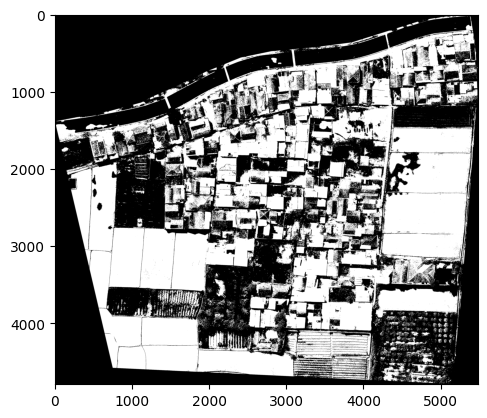

In [16]:
# load the image and perform pyramid mean shift filtering to aid the thresholding step
drive.mount('/content/drive')
image_path = '/content/drive/MyDrive/Kuliah S2/Semester 1/Computer Vision/content/Bandung.tif'
image = cv2.imread(image_path)
im = equalize(image)
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)

# convert the mean shift image to grayscale, then apply
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# the [1] in the last means take only the image and discard the threshold value
# cv2.thresh_binary+cv2.otsu is same as cv2.thresh_binary|cv2.thresh_otsu
plt.imshow(thresh, cmap=plt.get_cmap('gray'))

# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20,
                          labels=thresh)

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
        continue
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    # c = max(cnts, key=cv2.contourArea)

    # draw a circle enclosing the object
    # ((x, y), r) = cv2.minEnclosingCircle(c)
    # cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
    # cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
    # cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    # loop over the contours
    for (i, c) in enumerate(cnts):
        # draw the contour
        ((x, y), _) = cv2.minEnclosingCircle(c)
        cv2.putText(image, "#{}".format(i + 1), (int(x) - 10, int(y)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        cv2.drawContours(image, [c], -1, (0, 255, 0), 2)

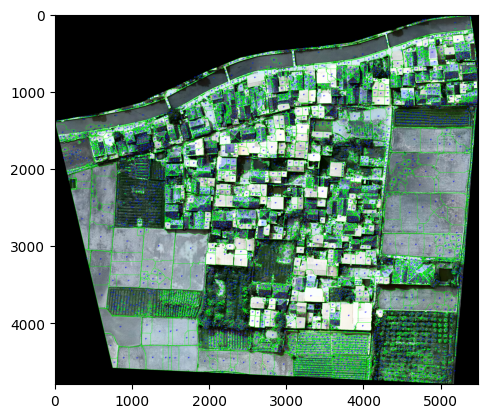

In [17]:
plt.figure()
plt.imshow(image, cmap='gray')
plt.show()